In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

### Read in data and fill missing

In [2]:
train = pd.read_csv('../input/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('../input/test.csv', parse_dates=['first_active_month'])
hist_trans = pd.read_csv('../input/historical_transactions.csv', parse_dates=['purchase_date'])
new_trans = pd.read_csv('../input/new_merchant_transactions.csv', parse_dates=['purchase_date'])

In [3]:
test.first_active_month.fillna(pd.to_datetime('2017-09-01'), inplace=True)

### Define model

In [4]:
exclude_feats = ['first_active_month', 'card_id', 'target']
cat_feats = ['feature_1', 'feature_2']

param = {
    'objective': 'regression',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    # 'lambda_l2': 5.0,
    'metric': 'rmse',
    'num_threads': 32,
}

In [6]:
def get_cv(feats, cat_feats=cat_feats):
    tr_data = lgb.Dataset(train[feats], label=train.target, categorical_feature=cat_feats)
    cv_scores = lgb.cv(param, tr_data, 3000, stratified=False, verbose_eval=200, early_stopping_rounds=600)
    print(f'Best cv scores {cv_scores["rmse-mean"][-1]} + {cv_scores["rmse-stdv"][-1]}\nNum of boost: {len(cv_scores["rmse-mean"])}')

In [7]:
feats = [col for col in train.columns if col not in exclude_feats]

get_cv(feats)

In [9]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.84916 + 0.0314835
[400]	cv_agg's rmse: 3.84904 + 0.0314254
[600]	cv_agg's rmse: 3.84904 + 0.0314057
[800]	cv_agg's rmse: 3.84905 + 0.0314026
Best cv scores 3.8490370670219667 + 0.03141751342723746
Num of boost: 450


### Calc reference date

In [8]:
hist_trans['purchase_year'] = hist_trans.purchase_date.dt.year
hist_trans['purchase_month'] = hist_trans.purchase_date.dt.month

hist_trans['ref_month_raw'] = hist_trans.purchase_month - hist_trans.month_lag
hist_trans['ref_year_raw'] = hist_trans.ref_month_raw // 12
hist_trans['ref_month'] = hist_trans.ref_month_raw % 12
hist_trans['ref_year'] = hist_trans.ref_year_raw + hist_trans.purchase_year
hist_trans['ref_date'] = hist_trans.ref_year.astype(str) + '-' + hist_trans.ref_month.astype(str)
hist_trans.ref_date.replace('2018-0', '2017-12', inplace=True)
hist_trans.drop(['ref_month_raw', 'ref_year_raw', 'ref_month', 'ref_year'], axis=1, inplace=True)

ref_date = hist_trans.groupby('card_id').ref_date.apply(lambda x: x.iloc[0])

ref_date = pd.to_datetime(ref_date)

### ref_anchor_diff

In [12]:
anchor_date = pd.to_datetime('2018-2-1')

train = train.join(ref_date, on='card_id')
train['anchor_date'] = anchor_date

test = test.join(ref_date, on='card_id')
test['anchor_date'] = anchor_date

train['ref_anchor_diff'] = (train.anchor_date.dt.year - train.ref_date.dt.year)*12 + (train.anchor_date.dt.month - train.ref_date.dt.month)

test['ref_anchor_diff'] = (test.anchor_date.dt.year - test.ref_date.dt.year)*12 + (test.anchor_date.dt.month - test.ref_date.dt.month)

In [17]:
exclude_feats += ['anchor_date', 'ref_date']

In [20]:
feats = [col for col in train.columns if col not in exclude_feats]

In [19]:
get_cv(feats)

[200]	cv_agg's rmse: 3.79759 + 0.0334537
[400]	cv_agg's rmse: 3.79503 + 0.0344419
[600]	cv_agg's rmse: 3.79524 + 0.0348927
Best cv scores 3.795027092003417 + 0.03442425236192733
Num of boost: 395


### active_ref_diff

In [18]:
train['active_ref_diff'] = (train.ref_date.dt.year - train.first_active_month.dt.year)*12 + (train.ref_date.dt.month - train.first_active_month.dt.month)

test['active_ref_diff'] = (test.ref_date.dt.year - test.first_active_month.dt.year)*12 + (test.ref_date.dt.month - test.first_active_month.dt.month)

In [20]:
feats = [col for col in train.columns if col not in exclude_feats]

In [22]:
get_cv(feats)

[200]	cv_agg's rmse: 3.78727 + 0.0341518
[400]	cv_agg's rmse: 3.78519 + 0.0351132
[600]	cv_agg's rmse: 3.78631 + 0.0354855
Best cv scores 3.7850810447528445 + 0.03499190753140942
Num of boost: 346


### active_anchor_diff (no effect)

这个值可通过 active_ref_diff 和 ref_anchor_diff 求得，信息重叠了

In [23]:
train['active_anchor_diff'] = (train.anchor_date.dt.year - train.first_active_month.dt.year)*12 + (train.anchor_date.dt.month - train.first_active_month.dt.month)

In [24]:
feats = [col for col in train.columns if col not in exclude_feats]

In [25]:
get_cv(feats)

[200]	cv_agg's rmse: 3.78876 + 0.03341
[400]	cv_agg's rmse: 3.78567 + 0.033823
[600]	cv_agg's rmse: 3.78669 + 0.0340359
Best cv scores 3.7856041538083085 + 0.033806035386171725
Num of boost: 378


### active_month/active_year (no effect)

In [20]:
train['active_month'] = train.first_active_month.dt.month
train['active_year'] = train.first_active_month.dt.year

In [21]:
test['active_month'] = test.first_active_month.dt.month
test['active_year'] = test.first_active_month.dt.year

In [27]:
feats = [col for col in train.columns if col not in exclude_feats]

In [28]:
get_cv(feats)

[200]	cv_agg's rmse: 3.78702 + 0.0333534
[400]	cv_agg's rmse: 3.78629 + 0.0334772
[600]	cv_agg's rmse: 3.78796 + 0.0335109
Best cv scores 3.785805664350682 + 0.03339485166259432
Num of boost: 280


### purchase_date

In [22]:
hist_trans['anchor_date'] = anchor_date

In [23]:
hist_trans.ref_date = pd.to_datetime(hist_trans.ref_date)

In [24]:
hist_trans['pur_ref_diff'] = (hist_trans.ref_date - hist_trans.purchase_date).dt.days

In [25]:
hist_pur_ref_diff_stats = hist_trans.groupby('card_id').agg({
    'pur_ref_diff': ['min', 'max', 'mean', 'median', 'sum', 'std']
})

In [26]:
def reset_cols(agg_df, prefix):
    agg_df.columns = [f'{prefix}_{"_".join(col)}' for col in agg_df.columns]

In [27]:
reset_cols(hist_pur_ref_diff_stats, 'hist')

In [28]:
train = train.join(hist_pur_ref_diff_stats, on='card_id')

test = test.join(hist_pur_ref_diff_stats, on='card_id')

In [30]:
feats = [col for col in train.columns if col not in exclude_feats]

In [37]:
get_cv(feats)

[200]	cv_agg's rmse: 3.77653 + 0.033861
[400]	cv_agg's rmse: 3.77344 + 0.0338537
[600]	cv_agg's rmse: 3.77354 + 0.0340263
[800]	cv_agg's rmse: 3.77411 + 0.0338486
Best cv scores 3.7732536164326276 + 0.03390607757820935
Num of boost: 476


In [31]:
new_trans = new_trans.join(ref_date, on='card_id')

In [32]:
new_trans['pur_ref_diff'] = (new_trans.purchase_date - new_trans.ref_date).dt.days

In [33]:
new_pur_ref_diff_stats = new_trans.groupby('card_id').agg({
    'pur_ref_diff': ['min', 'max', 'mean', 'median', 'sum', 'std']
})

In [34]:
reset_cols(new_pur_ref_diff_stats, 'new')

In [35]:
train = train.join(new_pur_ref_diff_stats, on='card_id')

In [36]:
test = test.join(new_pur_ref_diff_stats, on='card_id')

In [38]:
feats = [col for col in train.columns if col not in exclude_feats]

In [39]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.7361 + 0.0350328
[400]	cv_agg's rmse: 3.7263 + 0.035275
[600]	cv_agg's rmse: 3.72435 + 0.0348675
[800]	cv_agg's rmse: 3.72355 + 0.0347638
[1000]	cv_agg's rmse: 3.72341 + 0.0344007
[1200]	cv_agg's rmse: 3.72411 + 0.0343264
[1400]	cv_agg's rmse: 3.72473 + 0.0339708
Best cv scores 3.7233489788429113 + 0.03446631710325902
Num of boost: 975


In [40]:
train.shape, test.shape

((201917, 22), (123623, 21))

### purchase counts journey

In [37]:
hist_monthly_pur_cnts = hist_trans.groupby('card_id').month_lag.value_counts().unstack()
hist_monthly_pur_cnts.fillna(0, inplace=True)
hist_monthly_pur_cnts.columns = [f'hist_pur_cnts_monthlag{col}' for col in hist_monthly_pur_cnts.columns]

new_monthly_pur_cnts = new_trans.groupby('card_id').month_lag.value_counts().unstack()
new_monthly_pur_cnts.fillna(0, inplace=True)
new_monthly_pur_cnts.columns = [f'new_pur_cnts_monthlag{col}' for col in new_monthly_pur_cnts.columns]

train = train.join(hist_monthly_pur_cnts, on='card_id')
train = train.join(new_monthly_pur_cnts, on='card_id')

test = test.join(hist_monthly_pur_cnts, on='card_id')
test = test.join(new_monthly_pur_cnts, on='card_id')

In [41]:
feats = [col for col in train.columns if col not in exclude_feats]

In [49]:
get_cv(feats)

[200]	cv_agg's rmse: 3.73218 + 0.0345765
[400]	cv_agg's rmse: 3.72189 + 0.0346764
[600]	cv_agg's rmse: 3.71929 + 0.034604
[800]	cv_agg's rmse: 3.71845 + 0.0341597
[1000]	cv_agg's rmse: 3.7183 + 0.0340549
[1200]	cv_agg's rmse: 3.71873 + 0.0339464
Best cv scores 3.7182999789513453 + 0.034103732537671155
Num of boost: 991


### purchase amount

In [42]:
hist_trans['purchase_amount0'] = np.round(hist_trans['purchase_amount'] / 0.00150265118 + 497.06,2)
new_trans['purchase_amount0'] = np.round(new_trans['purchase_amount'] / 0.00150265118 + 497.06,2)

In [43]:
hist_pur_amount_stats = hist_trans.groupby('card_id').agg({
    'purchase_amount0': ['sum', 'min', 'max', 'mean', 'median', 'size', 'std']
})
reset_cols(hist_pur_amount_stats, 'hist')

new_pur_amount_stats = new_trans.groupby('card_id').agg({
    'purchase_amount0': ['sum', 'min', 'max', 'mean', 'median', 'size', 'std']
})
reset_cols(new_pur_amount_stats, 'new')

train = train.join(hist_pur_amount_stats, on='card_id')
train = train.join(new_pur_amount_stats, on='card_id')

test = test.join(hist_pur_amount_stats, on='card_id')
test = test.join(new_pur_amount_stats, on='card_id')

In [47]:
feats = [col for col in train.columns if col not in exclude_feats]

In [48]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.71505 + 0.0315578
[400]	cv_agg's rmse: 3.69899 + 0.0310104
[600]	cv_agg's rmse: 3.69327 + 0.0309122
[800]	cv_agg's rmse: 3.69098 + 0.0306848
[1000]	cv_agg's rmse: 3.69002 + 0.0301827
[1200]	cv_agg's rmse: 3.68999 + 0.0297786
[1400]	cv_agg's rmse: 3.68997 + 0.0293678
[1600]	cv_agg's rmse: 3.6899 + 0.0294197
[1800]	cv_agg's rmse: 3.68997 + 0.0292926
[2000]	cv_agg's rmse: 3.69002 + 0.0292724
[2200]	cv_agg's rmse: 3.69058 + 0.028725
[2400]	cv_agg's rmse: 3.69113 + 0.0286976
Best cv scores 3.6897968746355922 + 0.029078520227330675
Num of boost: 1909


In [57]:
del pur_amount_stats, new_pur_amount_stats

### purchase date delta

In [49]:
def calc_pur_date_delta(df):
    pur_date_sorted = df.purchase_date.sort_values()
    date_delta = (pur_date_sorted - pur_date_sorted.shift(1)).dt.days
    return pd.Series({
        'pur_date_delta_min': date_delta.min(),
        'pur_date_delta_max': date_delta.max(),
        'pur_date_delta_mean': date_delta.mean(),
        'pur_date_delta_median': date_delta.median(),
        'pur_date_delta_std': date_delta.std()
    })

In [50]:
hist_pur_date_delta = hist_trans.groupby('card_id').apply(calc_pur_date_delta)
hist_pur_date_delta.columns = [f'hist_{col}' for col in hist_pur_date_delta.columns]

In [51]:
new_pur_date_delta = new_trans.groupby('card_id').apply(calc_pur_date_delta)
new_pur_date_delta.columns = [f'new_{col}' for col in new_pur_date_delta.columns]

In [52]:
train = train.join(hist_pur_date_delta, on='card_id')
train = train.join(new_pur_date_delta, on='card_id')

In [53]:
test = test.join(hist_pur_date_delta, on='card_id')
test = test.join(new_pur_date_delta, on='card_id')

In [54]:
feats = [col for col in train.columns if col not in exclude_feats]

In [63]:
get_cv(feats)

[200]	cv_agg's rmse: 3.71228 + 0.0320781
[400]	cv_agg's rmse: 3.69494 + 0.0317819
[600]	cv_agg's rmse: 3.68912 + 0.0312993
[800]	cv_agg's rmse: 3.6865 + 0.0309692
[1000]	cv_agg's rmse: 3.6853 + 0.0310519
[1200]	cv_agg's rmse: 3.68476 + 0.0311188
[1400]	cv_agg's rmse: 3.6845 + 0.0313343
[1600]	cv_agg's rmse: 3.68439 + 0.0311712
[1800]	cv_agg's rmse: 3.68429 + 0.0310357
[2000]	cv_agg's rmse: 3.68449 + 0.0307374
Best cv scores 3.684166996209364 + 0.03108252573251932
Num of boost: 1737


In [64]:
del hist_pur_date_delta, new_pur_date_delta

### purchase amount journey hist and linear regression (no effect)

In [194]:
hist_monthly_pur_amount = hist_trans.groupby(['card_id', 'month_lag']).purchase_amount0.sum().unstack()
hist_monthly_pur_amount.fillna(0, inplace=True)
hist_monthly_pur_amount.columns = [f'hist_pur_amount_monghlag{col}' for col in hist_monthly_pur_amount.columns]

In [204]:
hist_monthly_pur_amount.head()

,hist_pur_amount_monghlag-13,hist_pur_amount_monghlag-12,hist_pur_amount_monghlag-11,hist_pur_amount_monghlag-10,hist_pur_amount_monghlag-9,hist_pur_amount_monghlag-8,hist_pur_amount_monghlag-7,hist_pur_amount_monghlag-6,hist_pur_amount_monghlag-5,hist_pur_amount_monghlag-4,hist_pur_amount_monghlag-3,hist_pur_amount_monghlag-2,hist_pur_amount_monghlag-1,hist_pur_amount_monghlag0
card_id,,,,,,,,,,,,,,
C_ID_00007093c1,0.0,1100.20,1168.90,1633.25,2691.13,2876.63,1307.79,4189.00,524.57,1513.59,940.25,1985.22,1186.59,1805.18
C_ID_0001238066,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,127.13,943.03,1831.55,4121.19,3884.94,2017.62
C_ID_0001506ef0,51.0,184.48,286.53,0.00,30.00,24.87,1017.00,849.50,770.50,910.74,1089.28,1579.29,1365.30,1620.25
C_ID_0001793786,0.0,0.00,0.00,0.00,1269.83,3745.99,7389.91,7783.04,3380.25,14441.70,13971.57,9683.56,14936.02,6282.35
C_ID_000183fdda,0.0,0.00,0.00,0.00,0.00,0.00,0.00,2831.40,1675.01,2326.11,2237.65,4312.91,8872.47,3510.10


In [211]:
def lsq(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    return np.linalg.lstsq(A, y, rcond=None)[0]

In [229]:
def pur_amount_lsq(y):
    x = np.arange(14)
    return pd.Series(lsq(x, y), index=['slope', 'intercept'])

In [232]:
slope_inter = hist_monthly_pur_amount.apply(pur_amount_lsq, axis=1)

In [234]:
train = train.join(slope_inter, on='card_id')

In [235]:
feats = [col for col in train.columns if col not in exclude_feats]

In [236]:
feats = [col for col in feats if col not in ['hist_category_2_nunique', 'new_category_2_nunique']]

In [237]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67675 + 0.0296724
[400]	cv_agg's rmse: 3.65597 + 0.0276718
[600]	cv_agg's rmse: 3.64882 + 0.0265396
[800]	cv_agg's rmse: 3.6456 + 0.0257452
[1000]	cv_agg's rmse: 3.64483 + 0.0249598
[1200]	cv_agg's rmse: 3.6444 + 0.0245319
[1400]	cv_agg's rmse: 3.64433 + 0.0239371
[1600]	cv_agg's rmse: 3.64435 + 0.02366
[1800]	cv_agg's rmse: 3.64459 + 0.0235053
Best cv scores 3.644175942702977 + 0.024150002386227058
Num of boost: 1335


In [168]:
new_monthly_pur_amount = new_trans.groupby(['card_id', 'month_lag']).purchase_amount0.sum().unstack()
new_monthly_pur_amount.fillna(0, inplace=True)
new_monthly_pur_amount.columns = [f'new_pur_amount_monghlag{col}' for col in new_monthly_pur_amount.columns]

In [200]:
#train = train.join(hist_monthly_pur_amount, on='card_id')
train = train.join(new_monthly_pur_amount, on='card_id')

In [354]:
#test = test.join(hist_monthly_pur_amount, on='card_id')
test = test.join(new_monthly_pur_amount, on='card_id')

In [199]:
# undo
train.drop(hist_monthly_pur_amount.columns, axis=1, inplace=True)
#train.drop(new_monthly_pur_amount.columns, axis=1, inplace=True)

In [201]:
feats = [col for col in train.columns if col not in exclude_feats]

In [202]:
feats = [col for col in feats if col not in ['hist_category_2_nunique', 'new_category_2_nunique']]

In [203]:
get_cv(feats)

[200]	cv_agg's rmse: 3.67556 + 0.029498
[400]	cv_agg's rmse: 3.65433 + 0.0286206
[600]	cv_agg's rmse: 3.64657 + 0.0275777
[800]	cv_agg's rmse: 3.64404 + 0.0266343
[1000]	cv_agg's rmse: 3.64262 + 0.0261078
[1200]	cv_agg's rmse: 3.64226 + 0.0254748
[1400]	cv_agg's rmse: 3.64237 + 0.0249391
[1600]	cv_agg's rmse: 3.64239 + 0.0243592
[1800]	cv_agg's rmse: 3.64283 + 0.0239157
Best cv scores 3.642215382334598 + 0.025350029933420924
Num of boost: 1249


In [70]:
del hist_monthly_pur_amount, new_monthly_pur_amount

### month_lag (no effect)

信息已被包含在 pur_ref_diff_stats 中了

In [71]:
hist_monthlag_stats = hist_trans.groupby('card_id').agg({
    'month_lag': ['min', 'max', 'mean', 'median', 'sum', 'std']
})
reset_cols(hist_monthlag_stats, 'hist')

In [72]:
new_monthlag_stats = new_trans.groupby('card_id').agg({
    'month_lag': ['min', 'max', 'mean', 'median', 'sum', 'std']
})
reset_cols(new_monthlag_stats, 'new')

In [73]:
train = train.join(hist_monthlag_stats, on='card_id')
train = train.join(new_monthlag_stats, on='card_id')

In [74]:
feats = [col for col in train.columns if col not in exclude_feats]

In [75]:
get_cv(feats)

[200]	cv_agg's rmse: 3.71356 + 0.0307921
[400]	cv_agg's rmse: 3.69626 + 0.030553
[600]	cv_agg's rmse: 3.69011 + 0.0308194
[800]	cv_agg's rmse: 3.68791 + 0.0310217
[1000]	cv_agg's rmse: 3.6865 + 0.0310134
[1200]	cv_agg's rmse: 3.68588 + 0.0308469
[1400]	cv_agg's rmse: 3.68591 + 0.0308816
[1600]	cv_agg's rmse: 3.68575 + 0.0307065
[1800]	cv_agg's rmse: 3.68564 + 0.0307191
[2000]	cv_agg's rmse: 3.68561 + 0.0305588
[2200]	cv_agg's rmse: 3.68603 + 0.0301023
Best cv scores 3.6855873417992036 + 0.03058826171965253
Num of boost: 1954


In [76]:
del hist_monthlag_stats, new_monthlag_stats

### authorized_flag

In [55]:
hist_trans.authorized_flag = hist_trans.authorized_flag.map({'Y': 1, 'N': 0})

In [56]:
auth_flag_stats = hist_trans.groupby('card_id').agg({
    'authorized_flag': ['sum', 'mean']
})
auth_flag_stats.columns = ['_'.join(col) for col in auth_flag_stats.columns]

In [57]:
train = train.join(auth_flag_stats, on='card_id')

In [58]:
test = test.join(auth_flag_stats, on='card_id')

In [59]:
feats = [col for col in train.columns if col not in exclude_feats]

In [81]:
get_cv(feats)

[200]	cv_agg's rmse: 3.70756 + 0.0310616
[400]	cv_agg's rmse: 3.68951 + 0.0301512
[600]	cv_agg's rmse: 3.68275 + 0.0297899
[800]	cv_agg's rmse: 3.67972 + 0.0296298
[1000]	cv_agg's rmse: 3.67833 + 0.0298503
[1200]	cv_agg's rmse: 3.67784 + 0.02969
[1400]	cv_agg's rmse: 3.67726 + 0.029423
[1600]	cv_agg's rmse: 3.67742 + 0.0292977
[1800]	cv_agg's rmse: 3.67719 + 0.0291284
[2000]	cv_agg's rmse: 3.67705 + 0.0292033
[2200]	cv_agg's rmse: 3.67748 + 0.0289491
Best cv scores 3.677017358436383 + 0.02914502937994817
Num of boost: 1965


In [82]:
del auth_flag_stats

### category_1

In [60]:
hist_trans.category_1 = hist_trans.category_1.map({'Y': 1, 'N': 0})
new_trans.category_1 = new_trans.category_1.map({'Y': 1, 'N': 0})

In [61]:
hist_category_1_stats = hist_trans.groupby('card_id').agg({
    'category_1': ['mean', 'sum']
})
reset_cols(hist_category_1_stats, 'hist')

In [62]:
new_category_1_stats = new_trans.groupby('card_id').agg({
    'category_1': ['mean', 'sum']
})
reset_cols(new_category_1_stats, 'new')

In [63]:
train = train.join(hist_category_1_stats, on='card_id')
train = train.join(new_category_1_stats, on='card_id')

In [64]:
test = test.join(hist_category_1_stats, on='card_id')
test = test.join(new_category_1_stats, on='card_id')

In [65]:
feats = [col for col in train.columns if col not in exclude_feats]

In [88]:
get_cv(feats)

[200]	cv_agg's rmse: 3.68659 + 0.029199
[400]	cv_agg's rmse: 3.6657 + 0.0284934
[600]	cv_agg's rmse: 3.6581 + 0.0274845
[800]	cv_agg's rmse: 3.65483 + 0.026864
[1000]	cv_agg's rmse: 3.65377 + 0.0266761
[1200]	cv_agg's rmse: 3.65336 + 0.0260115
[1400]	cv_agg's rmse: 3.65336 + 0.0258714
[1600]	cv_agg's rmse: 3.65334 + 0.0254449
[1800]	cv_agg's rmse: 3.65316 + 0.0252247
[2000]	cv_agg's rmse: 3.65337 + 0.0249635
Best cv scores 3.652987907789875 + 0.02519787808594584
Num of boost: 1713


In [89]:
del hist_category_1_stats, new_category_1_stats

### category_2 (no effect)

In [90]:
hist_trans.category_2 = hist_trans.category_2.fillna(0).astype(int)
new_trans.category_2 = new_trans.category_2.fillna(0).astype(int)

In [92]:
hist_trans = pd.get_dummies(hist_trans, columns=['category_2'])
new_trans = pd.get_dummies(new_trans, columns=['category_2'])

In [93]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,ref_date,anchor_date,pur_ref_diff,purchase_amount0,category_2_0,category_2_1,category_2_2,category_2_3,category_2_4,category_2_5
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,...,2018-02-01,2018-02-01,220,29.00,0,1,0,0,0,0
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,...,2018-02-01,2018-02-01,200,9.17,0,1,0,0,0,0
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,...,2018-02-01,2018-02-01,175,17.65,0,1,0,0,0,0
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,...,2018-02-01,2018-02-01,151,7.69,0,1,0,0,0,0
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,...,2018-02-01,2018-02-01,327,16.00,0,1,0,0,0,0


In [94]:
hist_category_2_stats = hist_trans.groupby('card_id').agg({
    'category_2_0': ['sum', 'mean'],
    'category_2_1': ['sum', 'mean'],
    'category_2_2': ['sum', 'mean'],
    'category_2_3': ['sum', 'mean'],
    'category_2_4': ['sum', 'mean'],
    'category_2_5': ['sum', 'mean']
})
reset_cols(hist_category_2_stats, 'hist')

In [95]:
new_category_2_stats = new_trans.groupby('card_id').agg({
    'category_2_0': ['sum', 'mean'],
    'category_2_1': ['sum', 'mean'],
    'category_2_2': ['sum', 'mean'],
    'category_2_3': ['sum', 'mean'],
    'category_2_4': ['sum', 'mean'],
    'category_2_5': ['sum', 'mean']
})
reset_cols(new_category_2_stats, 'new')

In [97]:
train = train.join(hist_category_2_stats, on='card_id')
train = train.join(new_category_2_stats, on='card_id')

In [98]:
feats = [col for col in train.columns if col not in exclude_feats]

In [99]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.68796 + 0.0271287
[400]	cv_agg's rmse: 3.66714 + 0.0262517
[600]	cv_agg's rmse: 3.65954 + 0.0252917
[800]	cv_agg's rmse: 3.65601 + 0.0244579
[1000]	cv_agg's rmse: 3.65472 + 0.0243091
[1200]	cv_agg's rmse: 3.65426 + 0.0240206
[1400]	cv_agg's rmse: 3.65413 + 0.0238947
[1600]	cv_agg's rmse: 3.65401 + 0.0235283
[1800]	cv_agg's rmse: 3.6542 + 0.0232334
Best cv scores 3.653976668312809 + 0.023549825064669138
Num of boost: 1596


### category_3 (no effect)

In [125]:
hist_trans.category_3.fillna('D', inplace=True)
new_trans.category_3.fillna('D', inplace=True)

In [159]:
hist_category_3_stats = hist_trans.groupby('card_id').category_3.nunique()
hist_category_3_stats.name = 'hist_category_3_nunique'

In [160]:
new_category_3_stats = new_trans.groupby('card_id').category_3.nunique()
new_category_3_stats.name = 'new_category_3_nunique'

In [161]:
train = train.join(hist_category_3_stats, on='card_id')
train = train.join(new_category_3_stats, )

In [166]:
# undo
train.drop('hist_category_3_nunique', axis=1, inplace=True)
train.drop('new_category_3_nunique', axis=1, inplace=True)

In [162]:
feats = [col for col in train.columns if col not in exclude_feats]

In [163]:
feats = [col for col in feats if col not in ['hist_category_2_nunique', 'new_category_2_nunique']]

In [164]:
get_cv(feats)

[200]	cv_agg's rmse: 3.67773 + 0.0307143
[400]	cv_agg's rmse: 3.65701 + 0.0293466
[600]	cv_agg's rmse: 3.65013 + 0.0281163
[800]	cv_agg's rmse: 3.64751 + 0.0275952
[1000]	cv_agg's rmse: 3.6464 + 0.0274098
[1200]	cv_agg's rmse: 3.646 + 0.0269346
[1400]	cv_agg's rmse: 3.64553 + 0.0264235
[1600]	cv_agg's rmse: 3.64575 + 0.0259107
[1800]	cv_agg's rmse: 3.64615 + 0.025335
[2000]	cv_agg's rmse: 3.64684 + 0.0250362
Best cv scores 3.645425664832311 + 0.026293678798491274
Num of boost: 1421


### category_3_dummy (no effect)

In [130]:
hist_category_3_dummy = pd.get_dummies(hist_trans.category_3)
hist_category_3_dummy.columns = [f'category_3_{col}' for col in hist_category_3_dummy.columns]
new_category_3_dummy = pd.get_dummies(new_trans.category_3)
new_category_3_dummy.columns = [f'category_3_{col}' for col in new_category_3_dummy.columns]

hist_trans = hist_trans.join(hist_category_3_dummy)
new_trans = new_trans.join(new_category_3_dummy)

In [148]:
hist_category_3_dummy_stats = hist_trans.groupby('card_id').agg({
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'category_3_D': ['mean']
})
reset_cols(hist_category_3_dummy_stats, 'hist')

In [149]:
new_category_3_dummy_stats = new_trans.groupby('card_id').agg({
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'category_3_D': ['mean']
})
reset_cols(new_category_3_dummy_stats, 'new')

In [150]:
train = train.join(hist_category_3_dummy_stats, on='card_id')
train = train.join(new_category_3_dummy_stats, on='card_id')

In [155]:
# undo
# train.drop(hist_category_3_dummy_stats.columns, axis=1, inplace=True)
# train.drop(new_category_3_dummy_stats.columns, axis=1, inplace=True)

In [156]:
feats = [col for col in train.columns if col not in exclude_feats]

In [157]:
feats = [col for col in feats if col not in ['hist_category_2_nunique', 'new_category_2_nunique']]

In [158]:
get_cv(feats)

[200]	cv_agg's rmse: 3.67657 + 0.0300134
[400]	cv_agg's rmse: 3.65552 + 0.0287861
[600]	cv_agg's rmse: 3.64826 + 0.027764
[800]	cv_agg's rmse: 3.64512 + 0.0272449
[1000]	cv_agg's rmse: 3.64361 + 0.0266741
[1200]	cv_agg's rmse: 3.64282 + 0.0263976
[1400]	cv_agg's rmse: 3.64241 + 0.0259892
[1600]	cv_agg's rmse: 3.64254 + 0.0252834
[1800]	cv_agg's rmse: 3.64309 + 0.0250574
[2000]	cv_agg's rmse: 3.64313 + 0.0248032
Best cv scores 3.642369763356643 + 0.02587606215295563
Num of boost: 1418


### auth_flag_encode

In [66]:
agg_funs = {}
for col in ['merchant_category_id', 'subsector_id', 'merchant_id', 'state_id', 'city_id']:
    hist_trans[col+'_auth_mean'] = hist_trans.groupby(col).authorized_flag.transform('mean')
    agg_funs[col+'_auth_mean'] = ['min', 'max', 'sum', 'mean', 'median', 'std']

In [67]:
ids_auth_mean_stats = hist_trans.groupby('card_id').agg(agg_funs)

reset_cols(ids_auth_mean_stats, 'hist')

In [68]:
train = train.join(ids_auth_mean_stats, on='card_id')

In [69]:
test = test.join(ids_auth_mean_stats, on='card_id')

In [70]:
feats = [col for col in train.columns if col not in exclude_feats]

In [72]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.68409 + 0.0292454
[400]	cv_agg's rmse: 3.66297 + 0.0276972
[600]	cv_agg's rmse: 3.65554 + 0.0269507
[800]	cv_agg's rmse: 3.65237 + 0.0264443
[1000]	cv_agg's rmse: 3.65108 + 0.0260441
[1200]	cv_agg's rmse: 3.65075 + 0.0257764
[1400]	cv_agg's rmse: 3.65054 + 0.0253575
[1600]	cv_agg's rmse: 3.65031 + 0.0252107
[1800]	cv_agg's rmse: 3.65033 + 0.0250707
[2000]	cv_agg's rmse: 3.6504 + 0.024722
[2200]	cv_agg's rmse: 3.65064 + 0.0242533
[2400]	cv_agg's rmse: 3.6511 + 0.0240769
Best cv scores 3.650195537390289 + 0.025096783423731207
Num of boost: 1913


In [73]:
train.shape, test.shape

((201917, 98), (123623, 97))

### category_3 auth_flag_encode (no effect)

In [238]:
hist_trans['category_3_auth_mean'] = hist_trans.groupby('category_3').authorized_flag.transform('mean')

In [239]:
hist_category_3_auth_encode_stats = hist_trans.groupby('card_id').agg({
    'category_3_auth_mean': ['min', 'max', 'median', 'mean', 'std']
})
reset_cols(hist_category_3_auth_encode_stats, 'hist')

In [240]:
train = train.join(hist_category_3_auth_encode_stats, on='card_id')

In [244]:
# undo
train.drop(hist_category_3_auth_encode_stats, axis=1, inplace=True)

In [246]:
feats = [col for col in train.columns if col not in exclude_feats]

In [247]:
feats = [col for col in feats if col not in ['hist_category_2_nunique', 'new_category_2_nunique', 'slope', 'intercept']]

In [248]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67556 + 0.029498
[400]	cv_agg's rmse: 3.65433 + 0.0286206
[600]	cv_agg's rmse: 3.64657 + 0.0275777
[800]	cv_agg's rmse: 3.64404 + 0.0266343
[1000]	cv_agg's rmse: 3.64262 + 0.0261078
[1200]	cv_agg's rmse: 3.64226 + 0.0254748
[1400]	cv_agg's rmse: 3.64237 + 0.0249391
[1600]	cv_agg's rmse: 3.64239 + 0.0243592
[1800]	cv_agg's rmse: 3.64283 + 0.0239157
Best cv scores 3.642215382334598 + 0.025350029933420865
Num of boost: 1249


### category_3_pur_amount_encode (no effect)

In [249]:
hist_trans['category_3_pur_amount_encode'] = hist_trans.groupby('category_3').purchase_amount.transform('mean')

In [250]:
new_trans['category_3_pur_amount_encode'] = new_trans.groupby('category_3').purchase_amount.transform('mean')

In [251]:
hist_category_3_pur_amount_encode_stats = hist_trans.groupby('card_id').agg({
    'category_3_pur_amount_encode': ['min', 'max', 'mean', 'sum']
})
reset_cols(hist_category_3_pur_amount_encode_stats, 'hist')

In [252]:
new_category_3_pur_amount_encode_stats = new_trans.groupby('card_id').agg({
    'category_3_pur_amount_encode': ['min', 'max', 'mean', 'sum']
})
reset_cols(new_category_3_pur_amount_encode_stats, 'new')

In [253]:
train = train.join(hist_category_3_pur_amount_encode_stats, on='card_id')
train = train.join(new_category_3_pur_amount_encode_stats, on='card_id')

In [257]:
# undo
train.drop(hist_category_3_pur_amount_encode_stats.columns, axis=1, inplace=True)
train.drop(new_category_3_pur_amount_encode_stats.columns, axis=1, inplace=True)

In [258]:
feats = [col for col in train.columns if col not in exclude_feats]

In [259]:
feats = [col for col in feats if col not in ['hist_category_2_nunique', 'new_category_2_nunique', 'slope', 'intercept']]

In [260]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67556 + 0.029498
[400]	cv_agg's rmse: 3.65433 + 0.0286206
[600]	cv_agg's rmse: 3.64657 + 0.0275777
[800]	cv_agg's rmse: 3.64404 + 0.0266343
[1000]	cv_agg's rmse: 3.64262 + 0.0261078
[1200]	cv_agg's rmse: 3.64226 + 0.0254748
[1400]	cv_agg's rmse: 3.64237 + 0.0249391
[1600]	cv_agg's rmse: 3.64239 + 0.0243592
[1800]	cv_agg's rmse: 3.64283 + 0.0239157
Best cv scores 3.642215382334598 + 0.025350029933420837
Num of boost: 1249


### purchase amount encode (no effect)

In [126]:
agg_funs = {}
for col in ['merchant_category_id', 'subsector_id', 'merchant_id', 'state_id', 'city_id']:
    hist_trans[col+'_pur_amount_mean'] = hist_trans.groupby(col).purchase_amount.transform('mean')
    hist_trans[col+'_pur_amount_sum'] = hist_trans.groupby(col).purchase_amount.transform('sum')
    agg_funs[col+'_pur_amount_mean'] = ['min', 'max', 'sum', 'mean', 'median', 'std']
    agg_funs[col+'_pur_amount_sum'] = ['min', 'max', 'sum', 'mean', 'median', 'std']

hist_ids_pur_amount_encode_stats = hist_trans.groupby('card_id').agg(agg_funs)

reset_cols(hist_ids_pur_amount_encode_stats, 'hist')

In [130]:
agg_funs = {}
for col in ['merchant_category_id', 'subsector_id', 'merchant_id', 'state_id', 'city_id']:
    new_trans[col+'_pur_amount_mean'] = new_trans.groupby(col).purchase_amount.transform('mean')
    new_trans[col+'_pur_amount_sum'] = new_trans.groupby(col).purchase_amount.transform('sum')
    agg_funs[col+'_pur_amount_mean'] = ['min', 'max', 'sum', 'mean', 'median', 'std']
    agg_funs[col+'_pur_amount_sum'] = ['min', 'max', 'sum', 'mean', 'median', 'std']

new_ids_pur_amount_encode_stats = new_trans.groupby('card_id').agg(agg_funs)

reset_cols(new_ids_pur_amount_encode_stats, 'new')

In [131]:
train = train.join(hist_ids_pur_amount_encode_stats, on='card_id')
train = train.join(new_ids_pur_amount_encode_stats, on='card_id')

In [132]:
feats = [col for col in train.columns if col not in exclude_feats]

In [133]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.68771 + 0.0284762
[400]	cv_agg's rmse: 3.66601 + 0.0278675
[600]	cv_agg's rmse: 3.65868 + 0.0274233
[800]	cv_agg's rmse: 3.65515 + 0.0272552
[1000]	cv_agg's rmse: 3.65372 + 0.0270195
[1200]	cv_agg's rmse: 3.65309 + 0.0265206
[1400]	cv_agg's rmse: 3.65299 + 0.0266464
[1600]	cv_agg's rmse: 3.65336 + 0.0263317
[1800]	cv_agg's rmse: 3.65358 + 0.0259817
Best cv scores 3.652831582881859 + 0.026474529384062237
Num of boost: 1285


### category_2 auth encode

In [71]:
hist_trans['category_2_auth_mean'] = hist_trans.groupby('category_2').authorized_flag.transform('mean')

In [72]:
hist_category_2_stats = hist_trans.groupby('card_id').agg({
    'category_2_auth_mean': ['min', 'max', 'sum', 'mean', 'median', 'std'],
})

reset_cols(hist_category_2_stats, 'hist')

In [73]:
train = train.join(hist_category_2_stats, on='card_id')

In [74]:
test = test.join(hist_category_2_stats, on='card_id')

In [78]:
feats = [col for col in train.columns if col not in exclude_feats]

In [79]:
get_cv(feats)

[200]	cv_agg's rmse: 3.68443 + 0.0291424
[400]	cv_agg's rmse: 3.66319 + 0.0278439
[600]	cv_agg's rmse: 3.65582 + 0.026866
[800]	cv_agg's rmse: 3.65261 + 0.0263305
[1000]	cv_agg's rmse: 3.65087 + 0.0260562
[1200]	cv_agg's rmse: 3.64997 + 0.0255376
[1400]	cv_agg's rmse: 3.64999 + 0.0253465
[1600]	cv_agg's rmse: 3.64971 + 0.0248838
[1800]	cv_agg's rmse: 3.65002 + 0.0243449
[2000]	cv_agg's rmse: 3.65044 + 0.0240948
[2200]	cv_agg's rmse: 3.65078 + 0.0238313
Best cv scores 3.6496642146142917 + 0.02468754886971473
Num of boost: 1659


### category_2 (no effect)

In [99]:
new_trans.category_2 = new_trans.category_2.fillna(0).astype(int)

In [100]:
hist_trans.category_2 = hist_trans.category_2.fillna(0).astype(int)

In [101]:
hist_category_2_stats = hist_trans.groupby('card_id').category_2.nunique()
hist_category_2_stats.name = 'hist_category_2_nunique'

In [102]:
new_category_2_stats = new_trans.groupby('card_id').category_2.nunique()
new_category_2_stats.name = 'new_category_2_nunique'

In [103]:
train = train.join(hist_category_2_stats, on='card_id')
train = train.join(new_category_2_stats, on='card_id')

In [104]:
test = test.join(hist_category_2_stats, on='card_id')
test = test.join(new_category_2_stats, on='card_id')

In [105]:
feats = [col for col in train.columns if col not in exclude_feats]

In [106]:
get_cv(feats)

[200]	cv_agg's rmse: 3.67718 + 0.0292867
[400]	cv_agg's rmse: 3.6568 + 0.0277609
[600]	cv_agg's rmse: 3.64974 + 0.0264312
[800]	cv_agg's rmse: 3.6469 + 0.0260231
[1000]	cv_agg's rmse: 3.64563 + 0.0260074
[1200]	cv_agg's rmse: 3.64591 + 0.0252574
[1400]	cv_agg's rmse: 3.64629 + 0.0247341
[1600]	cv_agg's rmse: 3.64635 + 0.0245029
Best cv scores 3.64554102722252 + 0.025925221991867642
Num of boost: 1017


### category_2_dummy

In [75]:
hist_category_2_dummy = pd.get_dummies(hist_trans.category_2)
hist_category_2_dummy.columns = [f'category_2_{col}' for col in hist_category_2_dummy.columns]

In [76]:
hist_trans = hist_trans.join(hist_category_2_dummy)

In [77]:
new_category_2_dummy = pd.get_dummies(new_trans.category_2)
new_category_2_dummy.columns = [f'category_2_{col}' for col in new_category_2_dummy.columns]

In [78]:
new_trans = new_trans.join(new_category_2_dummy)

In [80]:
hist_category_2_dummy_stats = hist_trans.groupby('card_id').agg({
    'category_2_0': ['mean'],
    'category_2_1': ['mean'],
    'category_2_2': ['mean'],
    'category_2_3': ['mean'],
    'category_2_4': ['mean'],
    'category_2_5': ['mean']   
})
reset_cols(hist_category_2_dummy_stats, 'hist')

KeyError: "Column 'category_2_1' does not exist!"

In [ ]:
new_category_2_dummy_stats = new_trans.groupby('card_id').agg({
    'category_2_0': ['mean'],
    'category_2_1': ['mean'],
    'category_2_2': ['mean'],
    'category_2_3': ['mean'],
    'category_2_4': ['mean'],
    'category_2_5': ['mean']   
})
reset_cols(new_category_2_dummy_stats, 'new')

In [ ]:
train = train.join(hist_category_2_dummy_stats, on='card_id')
train = train.join(new_category_2_dummy_stats, on='card_id')

In [ ]:
test = test.join(hist_category_2_dummy_stats, on='card_id')
test = test.join(new_category_2_dummy_stats, on='card_id')

In [115]:
feats = [col for col in train.columns if col not in exclude_feats]

In [119]:
feats = [col for col in feats if col not in ['hist_category_2_nunique', 'new_category_2_nunique']]

In [116]:
get_cv(feats)

[200]	cv_agg's rmse: 3.67624 + 0.029029
[400]	cv_agg's rmse: 3.65524 + 0.0278099
[600]	cv_agg's rmse: 3.64776 + 0.0269412
[800]	cv_agg's rmse: 3.64495 + 0.0262129
[1000]	cv_agg's rmse: 3.64368 + 0.025648
[1200]	cv_agg's rmse: 3.643 + 0.0248493
[1400]	cv_agg's rmse: 3.64294 + 0.0243906
[1600]	cv_agg's rmse: 3.64301 + 0.0239928
[1800]	cv_agg's rmse: 3.64314 + 0.0236254
[2000]	cv_agg's rmse: 3.64322 + 0.0234616
Best cv scores 3.642863801413514 + 0.024313742952366917
Num of boost: 1407


In [120]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67657 + 0.0300134
[400]	cv_agg's rmse: 3.65552 + 0.0287861
[600]	cv_agg's rmse: 3.64826 + 0.027764
[800]	cv_agg's rmse: 3.64512 + 0.0272449
[1000]	cv_agg's rmse: 3.64361 + 0.0266741
[1200]	cv_agg's rmse: 3.64282 + 0.0263976
[1400]	cv_agg's rmse: 3.64241 + 0.0259892
[1600]	cv_agg's rmse: 3.64254 + 0.0252834
[1800]	cv_agg's rmse: 3.64309 + 0.0250574
[2000]	cv_agg's rmse: 3.64313 + 0.0248032
Best cv scores 3.6423697633566428 + 0.025876062152955633
Num of boost: 1418


### merchant_id dup

In [81]:
def get_dup_stats(Se):
    cnts = Se.value_counts()
    return pd.Series({
        'mean': cnts.mean(),
        'median': cnts.median(),
        'min': cnts.min(),
        'max': cnts.max(),
        'std': cnts.std()
    })

In [82]:
hist_merchant_id_stats = hist_trans.groupby('card_id').merchant_id.apply(get_dup_stats).unstack()

In [83]:
hist_merchant_id_stats.columns = [f'hist_merchant_dup_{col}' for col in hist_merchant_id_stats.columns]

In [84]:
new_merchant_id_stats = new_trans.groupby('card_id').merchant_id.apply(get_dup_stats).unstack()
new_merchant_id_stats.columns = [f'new_merchant_dup_{col}' for col in new_merchant_id_stats.columns]

In [85]:
train = train.join(hist_merchant_id_stats, on='card_id')
train = train.join(new_merchant_id_stats, on='card_id')

In [86]:
test = test.join(hist_merchant_id_stats, on='card_id')
test = test.join(new_merchant_id_stats, on='card_id')

In [87]:
feats = [col for col in train.columns if col not in exclude_feats]

In [76]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.68409 + 0.0290234
[400]	cv_agg's rmse: 3.66229 + 0.0272745
[600]	cv_agg's rmse: 3.65508 + 0.0261339
[800]	cv_agg's rmse: 3.65155 + 0.0255135
[1000]	cv_agg's rmse: 3.65047 + 0.0251522
[1200]	cv_agg's rmse: 3.6499 + 0.0245406
[1400]	cv_agg's rmse: 3.65005 + 0.0240533
[1600]	cv_agg's rmse: 3.64998 + 0.0237164
[1800]	cv_agg's rmse: 3.65014 + 0.023541
Best cv scores 3.6498366245121296 + 0.024312069219729115
Num of boost: 1264


### dates

In [88]:
hist_trans['year'] = hist_trans.purchase_date.dt.year
hist_trans['month'] = hist_trans.purchase_date.dt.month
hist_trans['weekofyear'] = hist_trans.purchase_date.dt.weekofyear
hist_trans['dayofweek'] = hist_trans.purchase_date.dt.dayofweek
hist_trans['hour'] = hist_trans.purchase_date.dt.hour
hist_trans['weekend'] = (hist_trans.purchase_date.dt.weekday >=5).astype(int)

In [89]:
new_trans['year'] = new_trans.purchase_date.dt.year
new_trans['month'] = new_trans.purchase_date.dt.month
new_trans['weekofyear'] = new_trans.purchase_date.dt.weekofyear
new_trans['dayofweek'] = new_trans.purchase_date.dt.dayofweek
new_trans['hour'] = new_trans.purchase_date.dt.hour
new_trans['weekend'] = (new_trans.purchase_date.dt.weekday >=5).astype(int)

In [90]:
hist_dates_stats = hist_trans.groupby('card_id').agg({
    'year': ['nunique'],
    'month': ['nunique'],
    'weekofyear': ['nunique'],
    'dayofweek': ['nunique'],
    'hour': ['nunique'],
    'weekend': ['sum', 'mean']
})
reset_cols(hist_dates_stats, 'hist')

In [91]:
new_dates_stats = new_trans.groupby('card_id').agg({
    'year': ['nunique'],
    'month': ['nunique'],
    'weekofyear': ['nunique'],
    'dayofweek': ['nunique'],
    'hour': ['nunique'],
    'weekend': ['sum', 'mean']
})
reset_cols(new_dates_stats, 'new')

In [92]:
train = train.join(hist_dates_stats, on='card_id')
train = train.join(new_dates_stats, on='card_id')

In [93]:
test = test.join(hist_dates_stats, on='card_id')
test = test.join(new_dates_stats, on='card_id')

In [94]:
feats = [col for col in train.columns if col not in exclude_feats]

In [84]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67708 + 0.0295104
[400]	cv_agg's rmse: 3.65656 + 0.0281949
[600]	cv_agg's rmse: 3.64966 + 0.0273305
[800]	cv_agg's rmse: 3.64699 + 0.026829
[1000]	cv_agg's rmse: 3.64547 + 0.0266444
[1200]	cv_agg's rmse: 3.64527 + 0.0258394
[1400]	cv_agg's rmse: 3.64558 + 0.0256182
[1600]	cv_agg's rmse: 3.64553 + 0.025553
Best cv scores 3.6450963868564124 + 0.026175415456044408
Num of boost: 1128


### installments, merchant_id

In [95]:
hist_install_merchant_stats = hist_trans.groupby('card_id').agg({
    'installments': ['nunique', 'min', 'max', 'sum', 'mean', 'median', 'std'],
    'merchant_id': ['nunique']
})
reset_cols(hist_install_merchant_stats, 'hist')

In [96]:
new_install_merchant_stats = new_trans.groupby('card_id').agg({
    'installments': ['nunique', 'min', 'max', 'sum', 'mean', 'median', 'std'],
    'merchant_id': ['nunique']
})
reset_cols(new_install_merchant_stats, 'new')

In [97]:
train = train.join(hist_install_merchant_stats, on='card_id')
train = train.join(new_install_merchant_stats, on='card_id')

In [98]:
test = test.join(hist_install_merchant_stats, on='card_id')
test = test.join(new_install_merchant_stats, on='card_id')

In [99]:
feats = [col for col in train.columns if col not in exclude_feats]

In [100]:
get_cv(feats)

[200]	cv_agg's rmse: 3.67695 + 0.0294337
[400]	cv_agg's rmse: 3.65517 + 0.027743
[600]	cv_agg's rmse: 3.64748 + 0.0266374
[800]	cv_agg's rmse: 3.64421 + 0.0257476
[1000]	cv_agg's rmse: 3.64309 + 0.0251955
[1200]	cv_agg's rmse: 3.64265 + 0.0245461
[1400]	cv_agg's rmse: 3.64239 + 0.0240935
[1600]	cv_agg's rmse: 3.64249 + 0.023782
[1800]	cv_agg's rmse: 3.64293 + 0.0234009
Best cv scores 3.6422716121090217 + 0.024083163186012453
Num of boost: 1376


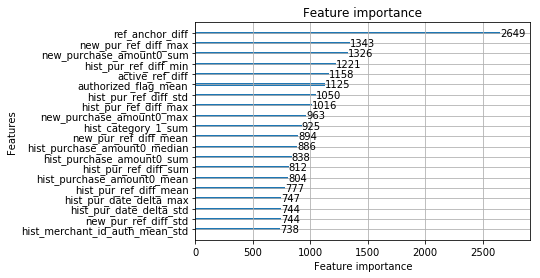

In [124]:
lgb.plot_importance(reg, max_num_features=20)

In [85]:
train.shape, test.shape

((201917, 130), (123623, 129))

### train a model

In [356]:
feats = imp_feats

In [361]:
tr_data = lgb.Dataset(train[feats], label=train.target, categorical_feature=cat_feats)

In [362]:
reg = lgb.train(param, tr_data, 1550, valid_sets=(tr_data), verbose_eval=100)

[100]	training's rmse: 3.66544
[200]	training's rmse: 3.58883
[300]	training's rmse: 3.54157
[400]	training's rmse: 3.50837
[500]	training's rmse: 3.48074
[600]	training's rmse: 3.4569
[700]	training's rmse: 3.43621
[800]	training's rmse: 3.41756
[900]	training's rmse: 3.4004
[1000]	training's rmse: 3.38403
[1100]	training's rmse: 3.36805
[1200]	training's rmse: 3.35259
[1300]	training's rmse: 3.33764
[1400]	training's rmse: 3.32252
[1500]	training's rmse: 3.30799


In [363]:
pred = reg.predict(test[feats])

submit_df = pd.DataFrame({
    'card_id': test.card_id,
    'target': pred
})

submit_df.to_csv('eda_cv3.643_50feats.csv', index=False)

### monthly auth (no effect)

In [261]:
hist_monthly_auth_mean = hist_trans.groupby(['card_id', 'month_lag']).authorized_flag.mean().unstack()
hist_monthly_auth_mean.fillna(0, inplace=True)
hist_monthly_auth_mean.columns = [f'hist_auth_mean_monghlag{col}' for col in hist_monthly_auth_mean.columns]

In [262]:
train = train.join(hist_monthly_auth_mean, on='card_id')

In [268]:
# undo
train.drop(hist_monthly_auth_mean.columns, axis=1, inplace=True)

KeyError: "['hist_auth_mean_monghlag-13' 'hist_auth_mean_monghlag-12'\n 'hist_auth_mean_monghlag-11' 'hist_auth_mean_monghlag-10'\n 'hist_auth_mean_monghlag-9' 'hist_auth_mean_monghlag-8'\n 'hist_auth_mean_monghlag-7' 'hist_auth_mean_monghlag-6'\n 'hist_auth_mean_monghlag-5' 'hist_auth_mean_monghlag-4'\n 'hist_auth_mean_monghlag-3' 'hist_auth_mean_monghlag-2'\n 'hist_auth_mean_monghlag-1' 'hist_auth_mean_monghlag0'] not found in axis"

In [269]:
feats = [col for col in train.columns if col not in exclude_feats]

In [270]:
feats = [col for col in feats if col not in ['hist_category_2_nunique', 'new_category_2_nunique', 'slope', 'intercept']]

In [271]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67556 + 0.029498
[400]	cv_agg's rmse: 3.65433 + 0.0286206
[600]	cv_agg's rmse: 3.64657 + 0.0275777
[800]	cv_agg's rmse: 3.64404 + 0.0266343
[1000]	cv_agg's rmse: 3.64262 + 0.0261078
[1200]	cv_agg's rmse: 3.64226 + 0.0254748
[1400]	cv_agg's rmse: 3.64237 + 0.0249391
[1600]	cv_agg's rmse: 3.64239 + 0.0243592
[1800]	cv_agg's rmse: 3.64283 + 0.0239157
Best cv scores 3.642215382334598 + 0.025350029933421017
Num of boost: 1249


### auth_split purchase amount (no effect)

In [267]:
auth_trans = hist_trans[hist_trans.authorized_flag == 1]
unauth_trans = hist_trans[hist_trans.authorized_flag == 0]

In [272]:
auth_pur_amount_stats = auth_trans.groupby('card_id').agg({
    'purchase_amount': ['min', 'max', 'mean', 'sum', 'std']
})
reset_cols(auth_pur_amount_stats, 'auth')

In [273]:
unauth_pur_amount_stats = unauth_trans.groupby('card_id').agg({
    'purchase_amount': ['min', 'max', 'mean', 'sum', 'std']
})
reset_cols(unauth_pur_amount_stats, 'unauth')

In [274]:
train = train.join(auth_pur_amount_stats, on='card_id')
train = train.join(unauth_pur_amount_stats, on='card_id')

In [278]:
exclude_feats += auth_pur_amount_stats.columns.tolist()
exclude_feats += unauth_pur_amount_stats.columns.tolist()
exclude_feats += ['hist_category_2_nunique', 'new_category_2_nunique', 'slope', 'intercept']

In [279]:
feats = [col for col in train.columns if col not in exclude_feats]

In [276]:
feats = [col for col in feats if col not in ['hist_category_2_nunique', 'new_category_2_nunique', 'slope', 'intercept']]

In [289]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 20, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8,
         "metric": 'rmse',
         "lambda_l2": 1.0,
         "nthread": 32,
}

In [288]:
get_cv(feats)

[200]	cv_agg's rmse: 3.67537 + 0.0299077
[400]	cv_agg's rmse: 3.65439 + 0.0284317
[600]	cv_agg's rmse: 3.64673 + 0.027161
[800]	cv_agg's rmse: 3.644 + 0.0262374
[1000]	cv_agg's rmse: 3.6429 + 0.0257288
[1200]	cv_agg's rmse: 3.64231 + 0.0251444
[1400]	cv_agg's rmse: 3.64254 + 0.0248431
[1600]	cv_agg's rmse: 3.64273 + 0.024317
Best cv scores 3.6422854682176378 + 0.025188426476119057
Num of boost: 1190


### auth_split category_1 (no effect)

In [290]:
auth_category_1_stats = auth_trans.groupby('card_id').agg({
    'category_1': ['sum', 'mean']
})
reset_cols(auth_category_1_stats, 'auth')

In [291]:
unauth_category_1_stats = unauth_trans.groupby('card_id').agg({
    'category_1': ['sum', 'mean']
})
reset_cols(unauth_category_1_stats, 'unauth')

In [292]:
train = train.join(auth_category_1_stats, on='card_id')
train = train.join(unauth_category_1_stats, on='card_id')

In [297]:
exclude_feats += auth_category_1_stats.columns.tolist()
exclude_feats += unauth_category_1_stats.columns.tolist()

In [279]:
feats = [col for col in train.columns if col not in exclude_feats]

In [293]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67648 + 0.0290966
[400]	cv_agg's rmse: 3.65553 + 0.0281392
[600]	cv_agg's rmse: 3.64826 + 0.0272128
[800]	cv_agg's rmse: 3.64567 + 0.0265311
[1000]	cv_agg's rmse: 3.64435 + 0.0259705
[1200]	cv_agg's rmse: 3.64402 + 0.0254622
[1400]	cv_agg's rmse: 3.64406 + 0.0251705
[1600]	cv_agg's rmse: 3.64424 + 0.0245112
[1800]	cv_agg's rmse: 3.64466 + 0.0240329
Best cv scores 3.6438177857472467 + 0.02529878391728963
Num of boost: 1249


### outlier encode (no effect)

In [295]:
train['outlier'] = (train.target < -33).astype(int)

In [296]:
for col in ['feature_1', 'feature_2', 'feature_3', 'active_month', 'active_year']:
    encoder = train.groupby(col).outlier.mean()
    train[col+'_outlier_ratio'] = train[col].map(encoder)

In [308]:
# undo
train.drop([col+'_outlier_ratio' for col in ['feature_1', 'feature_2', 'feature_3', 'active_month', 'active_year']], axis=1, inplace=True)

In [298]:
feats = [col for col in train.columns if col not in exclude_feats]

In [299]:
get_cv(feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67684 + 0.0294304
[400]	cv_agg's rmse: 3.65518 + 0.0279487
[600]	cv_agg's rmse: 3.64758 + 0.0266749
[800]	cv_agg's rmse: 3.64488 + 0.0263195
[1000]	cv_agg's rmse: 3.64389 + 0.0255278
[1200]	cv_agg's rmse: 3.64339 + 0.0250192
[1400]	cv_agg's rmse: 3.64309 + 0.0242173
[1600]	cv_agg's rmse: 3.64283 + 0.0239588
[1800]	cv_agg's rmse: 3.64331 + 0.0238594
[2000]	cv_agg's rmse: 3.6437 + 0.0235672
Best cv scores 3.6427684649124634 + 0.024046576239138282
Num of boost: 1590


### target encode (no effect)

In [300]:
for col in ['feature_1', 'feature_2', 'feature_3', 'active_month', 'active_year']:
    encoder = train.groupby(col).target.mean()
    train[col+'_target_mean'] = train[col].map(encoder)

In [309]:
# undo
train.drop([col+'_target_mean' for col in ['feature_1', 'feature_2', 'feature_3', 'active_month', 'active_year']], axis=1, inplace=True)

In [310]:
feats = [col for col in train.columns if col not in exclude_feats]

In [312]:
get_cv(feats)

[200]	cv_agg's rmse: 3.67708 + 0.0298926
[400]	cv_agg's rmse: 3.65575 + 0.0281684
[600]	cv_agg's rmse: 3.64822 + 0.0268817
[800]	cv_agg's rmse: 3.64558 + 0.0259915
[1000]	cv_agg's rmse: 3.64414 + 0.0255101
[1200]	cv_agg's rmse: 3.6438 + 0.0245959
[1400]	cv_agg's rmse: 3.64349 + 0.0238464
[1600]	cv_agg's rmse: 3.64336 + 0.0234687
[1800]	cv_agg's rmse: 3.64365 + 0.0231645
[2000]	cv_agg's rmse: 3.64391 + 0.0225009
Best cv scores 3.643109598982195 + 0.023542730767033074
Num of boost: 1515


In [316]:
exclude_feats += ['outlier']

### feature selection

In [319]:
feats = [col for col in train.columns if col not in exclude_feats]

In [320]:
tr_data = lgb.Dataset(train[feats], label=train.target, categorical_feature=cat_feats)

In [321]:
reg = lgb.train(param, tr_data, 1300, valid_sets=(tr_data), verbose_eval=100)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[100]	training's rmse: 3.66121
[200]	training's rmse: 3.58124
[300]	training's rmse: 3.53113
[400]	training's rmse: 3.49416
[500]	training's rmse: 3.46508
[600]	training's rmse: 3.43891
[700]	training's rmse: 3.41756
[800]	training's rmse: 3.39729
[900]	training's rmse: 3.37959
[1000]	training's rmse: 3.36172
[1100]	training's rmse: 3.34502
[1200]	training's rmse: 3.32702
[1300]	training's rmse: 3.31078


In [322]:
imp_df = pd.DataFrame({
    'features': feats,
    'split': reg.feature_importance('split'),
    'gain': reg.feature_importance('gain')
})

In [325]:
imp_df.sort_values('split', ascending=False).head()

,features,split,gain
3,ref_anchor_diff,1714,3.315809e+06
14,new_pur_ref_diff_max,941,1.565326e+06
42,new_purchase_amount0_sum,894,1.195613e+06
60,authorized_flag_mean,743,5.914505e+05
4,active_ref_diff,729,4.608616e+05


In [327]:
imp_df.shape

(155, 3)

In [330]:
imp_feats = imp_df.sort_values('split', ascending=False).head(100).features.tolist()

In [332]:
get_cv(imp_feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67795 + 0.0292643
[400]	cv_agg's rmse: 3.65664 + 0.028818
[600]	cv_agg's rmse: 3.64931 + 0.0279393
[800]	cv_agg's rmse: 3.64585 + 0.027078
[1000]	cv_agg's rmse: 3.64448 + 0.0266677
[1200]	cv_agg's rmse: 3.64395 + 0.0260567
[1400]	cv_agg's rmse: 3.64387 + 0.0256911
[1600]	cv_agg's rmse: 3.64395 + 0.0255697
[1800]	cv_agg's rmse: 3.64419 + 0.0249797
[2000]	cv_agg's rmse: 3.64424 + 0.0244675
Best cv scores 3.6438063612403213 + 0.025471497683094528
Num of boost: 1515


In [348]:
imp_feats = imp_df.sort_values('split', ascending=False).head(50).features.tolist()

In [349]:
imp_feats += cat_feats

In [344]:
get_cv(imp_feats)

/home/jiaz/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[200]	cv_agg's rmse: 3.67583 + 0.03035
[400]	cv_agg's rmse: 3.65456 + 0.029149
[600]	cv_agg's rmse: 3.64752 + 0.02793
[800]	cv_agg's rmse: 3.64496 + 0.0273282
[1000]	cv_agg's rmse: 3.64352 + 0.0270327
[1200]	cv_agg's rmse: 3.6431 + 0.0263975
[1400]	cv_agg's rmse: 3.64341 + 0.02608
[1600]	cv_agg's rmse: 3.6437 + 0.0257643
Best cv scores 3.6429845723901932 + 0.026436267046196248
Num of boost: 1165


In [366]:
feats = [col for col in train.columns if col not in exclude_feats]

In [369]:
train.shape

(201917, 179)

In [370]:
train.to_pickle('train179.pickle')

In [371]:
import pickle

In [373]:
with open('feats179.pickle', 'wb') as f:
    pickle.dump(feats, f)

In [374]:
with open('exclude_feats179.pickle', 'wb') as f:
    pickle.dump(exclude_feats, f)

In [21]:
new_trans['purchase_amount_is_int'] = new_trans.purchase_amount_new.apply(lambda x: x == np.round(x))

In [22]:
new_trans.purchase_amount_is_int.value_counts()

False    1122934
True      840097
Name: purchase_amount_is_int, dtype: int64

In [19]:
new_trans['purchase_amount_new'] = np.round(new_trans['purchase_amount'] / 0.00150265118 + 497.06,2)

In [20]:
new_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_amount_is_int,purchase_amount_new
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19,False,126.00
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19,False,118.01
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14,False,130.35
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8,False,49.90
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29,False,57.90


In [24]:
new_trans.purchase_amount_new.min(), new_trans.purchase_amount_new.max()

(0.01, 175625.86)

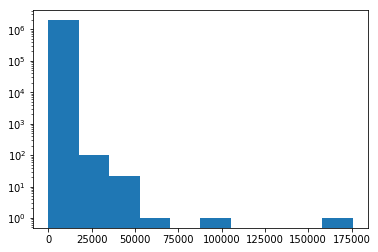

In [28]:
plt.hist(new_trans.purchase_amount_new)
plt.yscale('log')

In [ ]:
train['target_new'] = 

In [34]:
-np.log2(10)*10

-33.219280948873624

In [36]:
_34*np.log10(2)

-10.0

In [35]:
10**(_34*np.log10(2))

1e-10

In [37]:
2**(_34 / -10)

10.000000000000002

In [38]:
train['target_new'] = 10**(train['target']*np.log10(2))

In [40]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_new
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.566331
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1.313042
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,1.611111
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,1.103813
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.895181


In [41]:
train.target_new.min(), train.target_new.max()

(9.99999999219256e-11, 255873.00087254902)

(array([2.2070e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0000e+00, 1.0000e+00, 6.0000e+00, 6.0000e+00, 8.0000e+00,
        4.0000e+00, 1.4000e+01, 2.9000e+01, 5.0000e+01, 1.3500e+02,
        2.5100e+02, 6.6600e+02, 1.4920e+03, 3.0540e+03, 6.7100e+03,
        1.6108e+04, 4.0764e+04, 6.9713e+04, 3.6022e+04, 1.3775e+04,
        5.9710e+03, 2.6400e+03, 1.2540e+03, 5.9500e+02, 2.5900e+02,
        8.1000e+01, 4.4000e+01, 2.1000e+01, 1.3000e+01, 6.0000e+00,
        6.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-33.21928095, -32.19559396, -31.17190698, -30.14821999,
        -29.124533  , -28.10084601, -27.07715903, -26.05347204,
        -25.02978505, -24.00609807, -22.98241108, -21.95872409,
        -20.93503711, -19.91135012, -18.88766313, -17.86397614,
        -16.84028916, -15.81660217, -14.79291518, -13.7692282 

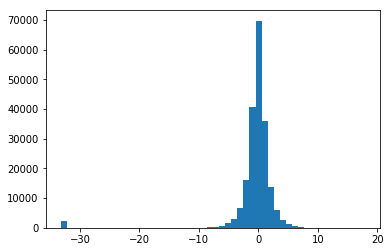

In [42]:
plt.hist(train.target, bins=50)

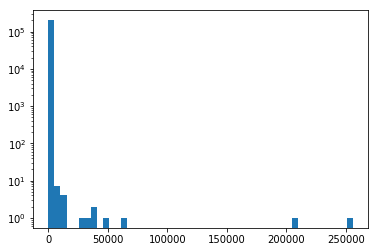

In [44]:
plt.hist(train.target_new, bins=50)
plt.yscale('log')

(array([102678.,  58222.,  16313.,   7121.,   3879.,   2588.,   1801.,
          1276.,    967.,    791.]),
 array([9.99999999e-11, 9.99999997e-01, 1.99999999e+00, 2.99999999e+00,
        3.99999999e+00, 4.99999998e+00, 5.99999998e+00, 6.99999998e+00,
        7.99999997e+00, 8.99999997e+00, 9.99999997e+00]),
 <a list of 10 Patch objects>)

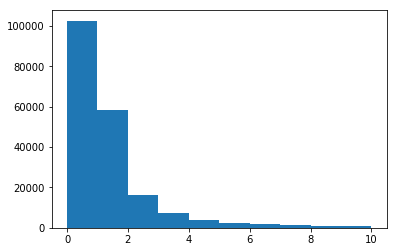

In [57]:
plt.hist(train[train.target_new < 10].target_new)
#plt.yscale('log')

In [65]:
train[train.target_new < 1e-6]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_new
64,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,1.000000e-10
92,2015-05-01,C_ID_b9379a30ea,3,3,1,-33.219281,1.000000e-10
125,2015-10-01,C_ID_e9120f535c,3,3,1,-33.219281,1.000000e-10
151,2017-03-01,C_ID_65715cb80d,4,2,0,-33.219281,1.000000e-10
225,2017-01-01,C_ID_ae77d244b6,2,1,0,-33.219281,1.000000e-10
248,2015-07-01,C_ID_c4262c902e,5,1,1,-33.219281,1.000000e-10
254,2017-03-01,C_ID_6a2c823e5f,2,1,0,-33.219281,1.000000e-10
386,2017-06-01,C_ID_98e1cb10b6,2,3,0,-33.219281,1.000000e-10
467,2017-03-01,C_ID_eb8175721a,4,1,0,-33.219281,1.000000e-10
515,2016-04-01,C_ID_a2580006bf,4,2,0,-33.219281,1.000000e-10


In [60]:
(train.target < -33).sum()

2207